# import libraries

In [244]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

from IPython.display import display
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb

# preparing the dataset

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

Preparing the dataset
For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'

Preparation:

- Fill missing values with zeros.
- Apply the log transform to median_house_value.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [245]:
data = pd.read_csv('housing.csv')
df = data.copy()

In [246]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [247]:
# First, keep only the records where ocean_proximity is either '<1H OCEAN' or 'INLAND'
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [248]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [249]:
df= df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND' )]
df.ocean_proximity.value_counts()

<1H OCEAN    9136
INLAND       6551
Name: ocean_proximity, dtype: int64

In [251]:
df['ocean_proximity'] =  df['ocean_proximity'].replace(
    {'<1H OCEAN':"h_ocean","INLAND":"inland" })


In [252]:
df.ocean_proximity.value_counts()

h_ocean    9136
inland     6551
Name: ocean_proximity, dtype: int64

In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [254]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [255]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

<AxesSubplot:>

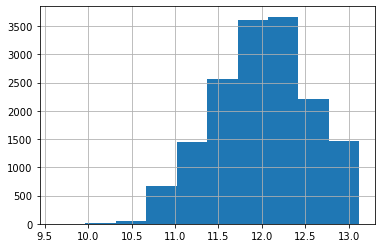

In [256]:
df.median_house_value = np.log1p(df.median_house_value)
# target
df.median_house_value.hist()

In [257]:
df.shape

(15687, 10)

In [258]:
df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25, random_state=1)

In [259]:
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

In [260]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [261]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [262]:
df_train.ocean_proximity.value_counts()

h_ocean    5487
inland     3924
Name: ocean_proximity, dtype: int64

In [263]:
train_dicts = df_train.fillna(0).to_dict(orient = "records")
dv=  DictVectorizer(sparse = False)

X_train = dv.fit_transform(train_dicts)
dv.get_feature_names()

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=h_ocean',
 'ocean_proximity=inland',
 'population',
 'total_bedrooms',
 'total_rooms']

In [264]:
dv = DictVectorizer(sparse = False)

train_dict = df_train.to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient = 'records')
X_val = dv.transform(val_dict)

# Q1 DecisionTreeRegressor
 

In [265]:
# Let's train a decision tree regressor to predict the
# median_house_value variable.

#Train a model with max_depth=1

In [266]:
dt = DecisionTreeRegressor(max_depth = 1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [267]:
 print(export_text(dt, feature_names = dv.get_feature_names()))

|--- ocean_proximity=h_ocean <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=h_ocean >  0.50
|   |--- value: [12.30]



C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Which feature is used for splitting the data?

- ocean_proximity
- total_rooms
- latitude
- population
The answer is ocean_proximity

# Q2 random forest

In [268]:
"""
Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)
What's the RMSE of this model on validation?

0.045
0.245
0.545
0.845

"""

"\nTrain a random forest model with these parameters:\n\nn_estimators=10\nrandom_state=1\nn_jobs=-1 (optional - to make training faster)\nWhat's the RMSE of this model on validation?\n\n0.045\n0.245\n0.545\n0.845\n\n"

In [269]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1 )
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [270]:
y_pred_rf = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_rf)) 
print("rmse: ",rmse.round(3))
#the answer is rmse =  0.245 

rmse:  0.245


# Q3 n_estimators of Random Forest Regressor

In [271]:
'''
Try different values of this parameter from 10 to 200 with step 10.
Set random_state to 1.
Evaluate the model on the validation dataset.
After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

10
25
50
160

'''

'\nTry different values of this parameter from 10 to 200 with step 10.\nSet random_state to 1.\nEvaluate the model on the validation dataset.\nAfter which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.\n\n10\n25\n50\n160\n\n'

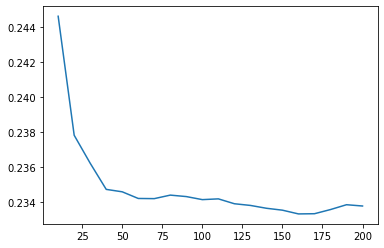

In [272]:
rmse_scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    rmse_scores.append((n, rmse))

columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(rmse_scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.rmse)

# based on the plot I would choose 160.

# Q 4  select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values,
try different values of n_estimators from 10 till 200 (with step 10)
calculate the mean RMSE
Fix the random seed: random_state=1
What's the best max_depth, using the mean RMSE?

10
15
20
25

In [275]:
rmse_scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(max_depth=d,
                                   n_estimators=n,
                                   random_state=1, 
                                   n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        rmse_scores.append((d, n, rmse))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(rmse_scores, columns=columns)

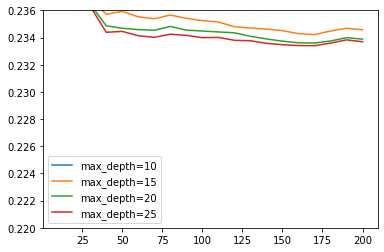

In [276]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label = 'max_depth=%d' % d)

plt.ylim(0.22, 0.236)

plt.legend()
# max_dept= 25 has the lowest rmse, so this is a good parameter

# Q5  feature importance information

For this homework question, we'll find the most important feature:

Train the model with these parameters:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature (among these 4)?

total_rooms
median_income
total_bedrooms
longitude

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<BarContainer object of 10 artists>

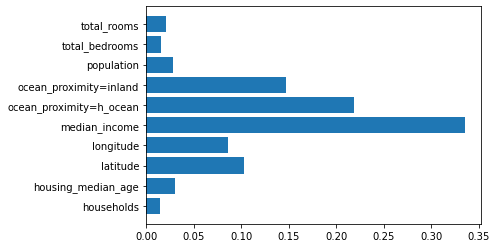

In [277]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20,
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
plt.barh(dv.get_feature_names(), rf.feature_importances_)

In [ ]:
# so, the most important feature is median_income

# Q6 XGBoost 

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

0.3
0.1
Both give equal value

In [278]:
features = dv.get_feature_names()
features

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity=h_ocean',
 'ocean_proximity=inland',
 'population',
 'total_bedrooms',
 'total_rooms']

In [279]:
def parse_xgb_output(output):
    results = []

    for line in output.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [280]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [283]:
scores ={}

In [287]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

watchlist = [(dtrain, 'train'), (dval, 'val')]

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model  = xgb.train(xgb_params, dtrain, num_boost_round = 100)

In [288]:
%%capture output_eta_03
 
xgb_params['eta'] = 0.3
xgb.train(xgb_params, dtrain, num_boost_round=100,
          verbose_eval=5, evals=watchlist)

In [289]:
%%capture output_eta_01
 
xgb_params['eta'] = 0.1
xgb.train(xgb_params, dtrain, num_boost_round=100,
          verbose_eval=5, evals=watchlist)


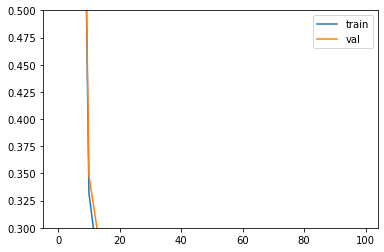

In [290]:
df_score_eta_03 = parse_xgb_output(output_eta_03.stdout)
plt.plot(df_score_eta_03.num_iter, df_score_eta_03.train_rmse, label='train')
plt.plot(df_score_eta_03.num_iter, df_score_eta_03.val_rmse, label='val')
plt.ylim(0.3, 0.5)
plt.legend()

In [296]:
df_score_eta_03.tail()

,num_iter,train_rmse,val_rmse
16,80,0.12835,0.23045
17,85,0.12534,0.23010
18,90,0.12174,0.22957
19,95,0.11894,0.22906
20,99,0.11656,0.22897


In [295]:
df_score_eta_01.tail()

,num_iter,train_rmse,val_rmse
16,80,0.18145,0.23594
17,85,0.17807,0.23475
18,90,0.17418,0.23307
19,95,0.17149,0.23258
20,99,0.17000,0.23234


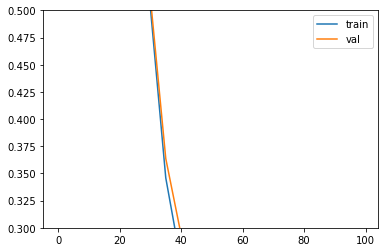

In [291]:
df_score_eta_01 = parse_xgb_output(output_eta_01.stdout)
plt.plot(df_score_eta_01.num_iter, df_score_eta_01.train_rmse, label='train')
plt.plot(df_score_eta_01.num_iter, df_score_eta_01.val_rmse, label='val')
plt.ylim(0.3, 0.5)
plt.legend()

In [297]:
y_pred  = model.predict(dval)
y_pred 

array([12.136063, 12.115129, 11.55087 , ..., 11.960862, 11.147743,
       11.804589], dtype=float32)